In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import itertools
import sys
import re
import itertools
from io import StringIO
from tqdm.auto import tqdm
from pprint import pprint

import urllib.request
import requests


from dfply import *
import geopandas as gpd

from ast import literal_eval
from shapely.geometry import shape

# ! pip install geemap
# import geemap

In [3]:
# authenticate earthengine api
ee.Initialize()

In [106]:
from Modules.Modules import filter_exclude, get_img_df
from Modules.Parallize_df import parallelize_dataframe
from Modules.Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# import the 30m landcover of 2010
LUCC_2010 = ee.Image("users/wangjinzhulala/Paper_3/01_LUCC_1990_2019_china/CLCD_v01_2010").mask(NCP_img_mask)
lucc_code = dict(zip([f"{i}" for i in range(1,10)],['Cropland','Forest','Shrub','Grassland','Water','Sonw','Barren','Impervious','Wetland']))

# the crop land of 2010
cropland_2010 = LUCC_2010.eq(1).mask(NCP_img_mask)

# the GAEZ_2010_cropland layers
actual_area = pd.read_pickle('./result_csv/actual_area.pkl')
GAEZ_cropland_2010_corrected = pd.read_pickle('./result_csv/GAEZ_cropland_2010_corrected.pkl')

# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

# urban imgs
NCP_urban_maps = ee.Image("users/wangjinzhulala/China_built_up/06_temporal_corrected_classification/Mosaic_only_forward_China_huadong_sample_ensemble")
NCP_urban_2010 = NCP_urban_maps.gte(4).mask(NCP_img_mask)

Unet_transition_potential = ee.Image(f"users/wangjinzhulala/Paper_3/06_Urban_projection/trainsition_potential_{proj_yr_selected[0]}_{proj_yr_selected[1]}")

# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# threshould for UNET_tarnsition potential map
SSP_urban_count = pd.read_csv('./result_csv/SSP_GDP_Pop_future_pred_treshold.csv')

### 1) Get historical and future urban maps

In [135]:
# function to 1) clip an img with a boundary, then 2) binarize the img
def clip_binarize(img,shp,threshold):

  # 1) clip the img
  img = ee.Image(img).clip(shp)

  # 2) binarize the img
  img = ee.Image(img).gte(threshold)

  return img

In [136]:
# get future urban maps

# 1) get the future urban maps under different SSPs
SSP_future_urban_map = SSP_urban_count.copy()
SSP_future_urban_map['Urban_map'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold']),1)

SSP_future_urban_map['Urban_map_top'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold_top']),1)

SSP_future_urban_map['Urban_map_bot'] = SSP_future_urban_map.apply(lambda row: clip_binarize(Unet_transition_potential,
                                        NCP_shp.filter(ee.Filter.eq('EN_Name',row['Province'])),
                                        row['threshold_bot']),1)

# 2) mosaic the urban maps of differnect provinces but the same year/ssp into a single img
SSP_future_urban_map = SSP_future_urban_map.groupby(['Scenario','year'])\
                    .apply(lambda x,idx:[ee.ImageCollection(x['Urban_map'].tolist()).mosaic(),
                                ee.ImageCollection(x['Urban_map_top'].tolist()).mosaic(),
                                ee.ImageCollection(x['Urban_map_bot'].tolist()).mosaic()],1).reset_index()

SSP_future_urban_map[['Urban_map','Urban_map_top','Urban_map_bot']] =  SSP_future_urban_map[0].values.tolist()
SSP_future_urban_map = SSP_future_urban_map.drop(0,1)                           
SSP_future_urban_map

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2368\1839447144.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,Scenario,year,Urban_map,Urban_map_top,Urban_map_bot
0,SSP1,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,SSP1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,SSP1,2030,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2035,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2040,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...
80,SSP5,2080,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
81,SSP5,2085,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
82,SSP5,2090,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
83,SSP5,2095,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### compute the area of pred/historical urban

In [137]:
# function to compute areas of predicted urban maps
def get_stats(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    ssp = row['Scenario']
    year = row['year']

    urban_img = row['Urban_map']
    urban_img_bot = row['Urban_map_top']
    urban_img_top = row['Urban_map_bot']

    # get the input images
    in_img = ee.Image([urban_img.mask(urban_img.gte(1)),
               urban_img_bot.mask(urban_img_bot.gte(1)),
               urban_img_top.mask(urban_img_top.gte(1))])
    
    in_img_size = in_img.bandNames().size().getInfo()
    reducer = ee.Reducer.sum().repeat(in_img_size)

    # compute the area of the input img
    stats = ee.Image([ee.Image().pixelArea()]*in_img_size)\
          .updateMask(in_img)\
          .reduceRegions(collection=NCP_shp,
                  scale=30,
                  reducer='sum').getInfo()

    # contructe the stats_df, divide 1e9 is to convert m2 to 1000 km2
    stats_data = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['area']/1e9,
                                  i['properties']['area_1']/1e9,
                                  i['properties']['area_2']/1e9] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_1000_km2','area_1000_km2_bot','area_1000_km2_top']
    stats_data['year'] = year
    stats_data['ssp'] = ssp

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [139]:
# # get the stats
# future_pred_area = parallelize_dataframe(SSP_future_urban_map,get_stats,30)

# # save to disk
# future_pred_area.to_csv('./result_csv/future_pred_area.csv',index=False)

# read data
future_pred_area = pd.read_csv('./result_csv/future_pred_area.csv')

#### compute the historical urban area

In [86]:
# read NCP urban 
historical_urbans = {k:[ee.Image(NCP_urban_maps.gte(v))] for k,v in zip(range(1991,2019,3),range(10,0,-1))}
historical_urban_df = pd.DataFrame(historical_urbans).T.reset_index()
historical_urban_df.columns = ['year','img']

In [87]:
# function to compute the urban area for each province
def compute_area(in_df):
  print(' ',end='',flush=True)

  out_dfs = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    year = row['year']
    img = ee.Image().pixelArea().updateMask(row['img'])
    
    stats = img.reduceRegions(collection=NCP_shp,scale=30,reducer='sum').getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()

    stats_df['year'] = year
    stats_df.columns = ['Province','area_m2','year']

    out_dfs.append(stats_df)

  return pd.concat(out_dfs)

In [140]:
# # get stats
# historical_urban_area = parallelize_dataframe(historical_urban_df,compute_area,10)
# historical_urban_area['area_1000_km2'] = historical_urban_area['area_m2']/1000/1000/1000
# historical_urban_area['area_k_ha'] = historical_urban_area['area_m2']/100/100/1000
# historical_urban_area.to_csv('./result_csv/historical_urban_area.csv',index=False)

historical_urban_area = pd.read_csv('./result_csv/historical_urban_area.csv')

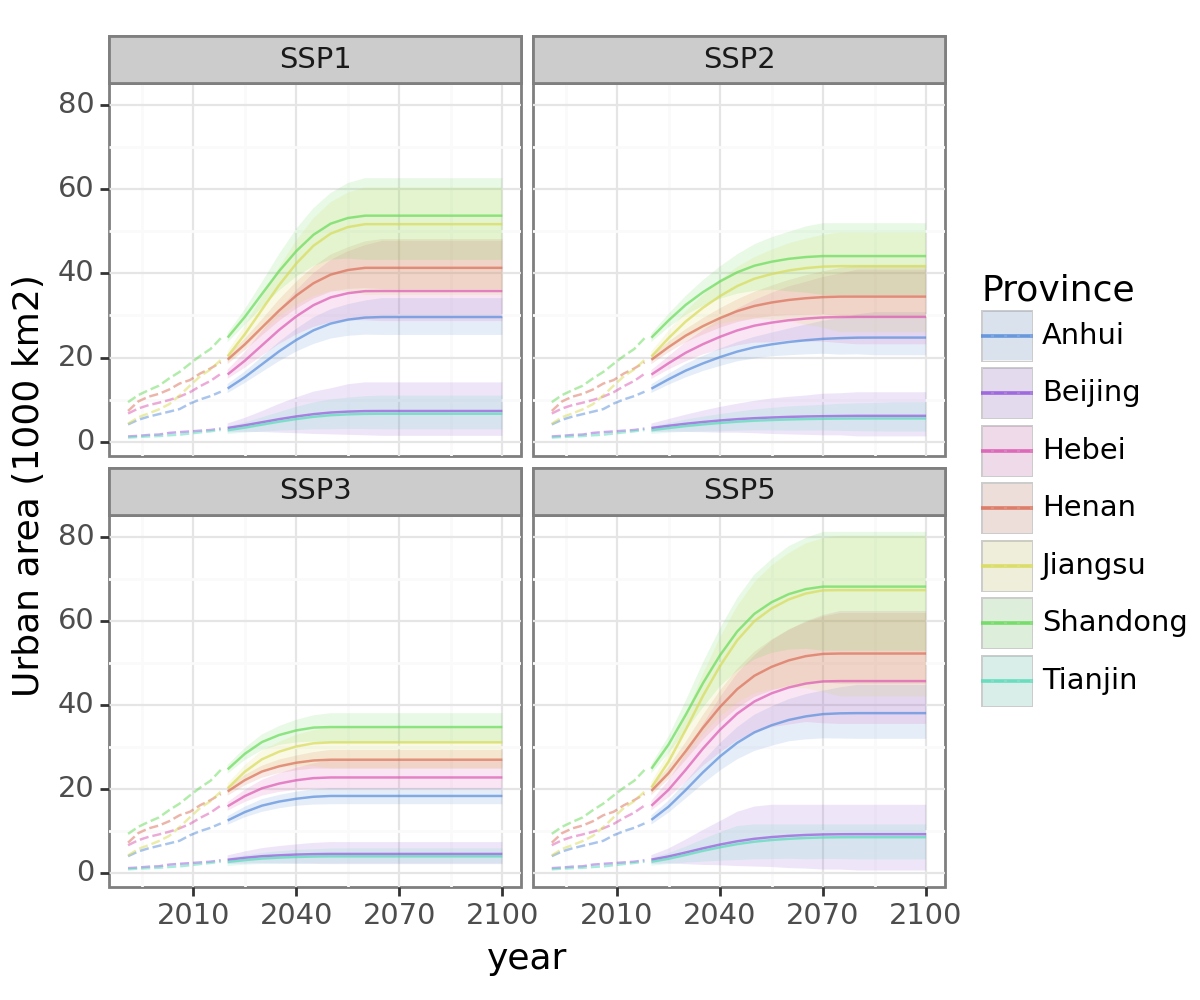

<Figure Size: (600 x 500)>

In [141]:
# plot the area change
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

g = (ggplot()
  # urban area hist
  + geom_line(historical_urban_area,aes(x='year',y='area_1000_km2',color='Province'),alpha=0.5,linetype='dashed')
  # urban area pred
  + geom_ribbon(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',ymin='area_1000_km2_bot',
                                    ymax='area_1000_km2_top',fill='Province'),alpha=0.15)
  + geom_line(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',y='area_1000_km2',color='Province'),alpha=0.7)

  + facet_wrap('ssp',nrow=2)
  + theme_bw(base_size=13)
  + scale_color_discrete(h=.6) 
  + scale_fill_discrete(h=.6)  
  + ylab('Urban area (1000 km2)')
#   + theme(legend_position=(1,0.5))
)

# show img
g

In [142]:
g.save('../Figs/result_2_1_1_pred_urban_area.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_1_1_pred_urban_area.svg


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


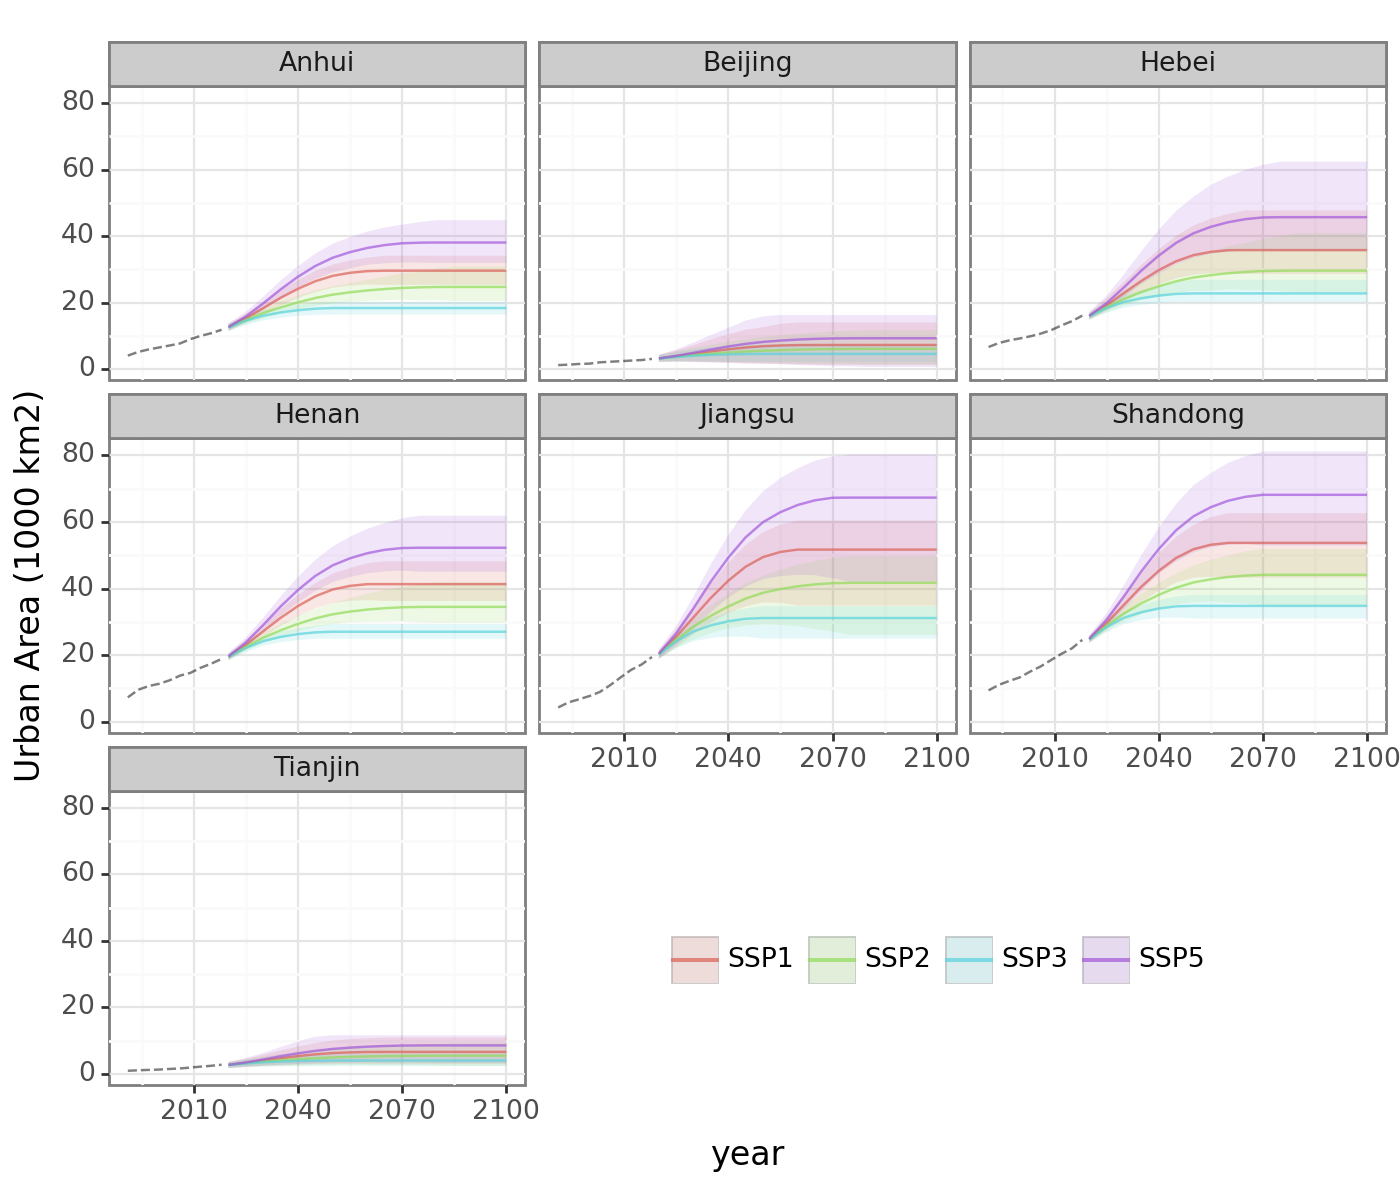

<Figure Size: (700 x 600)>

In [143]:
# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

g = (ggplot()
  # urban area hist
  + geom_line(historical_urban_area,aes(x='year',y='area_1000_km2'),alpha=0.5,linetype='dashed')
  # urban area pred
  + geom_ribbon(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',ymin='area_1000_km2_bot',
                                    ymax='area_1000_km2_top',fill='ssp'),alpha=0.15)
  + geom_line(future_pred_area >> mask(~X.ssp.isin(['SSP4'])),aes(x='year',y='area_1000_km2',color='ssp'),alpha=0.7)
  + facet_wrap('Province',ncol=3)
  + theme_bw(base_size=12)
  + theme(subplots_adjust={'wspace': 0.1})
  + ylab('Urban Area (1000 km2)')
  + theme(legend_title=element_blank(),legend_position=(0.67,0.2),legend_background=element_blank())
 )

g

In [144]:
g.save('../Figs/result_2_1_2_pred_urban_area.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 7 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_1_2_pred_urban_area.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


#### Overlay the future_urban_maps with cropland_2010 to get urbanization encroachment on cropland

In [145]:
# overlay urban-furture with cropland-2010 to get the urban encroachment on cropland
SSP_future_urban_map['Urban_encroachment_map'] = SSP_future_urban_map.apply(lambda row: cropland_2010.add(row['Urban_map']).eq(2),axis=1)
SSP_future_urban_map['Urban_encroachment_map_top'] = SSP_future_urban_map.apply(lambda row: cropland_2010.add(row['Urban_map_top']).eq(2),axis=1)
SSP_future_urban_map['Urban_encroachment_map_bot'] = SSP_future_urban_map.apply(lambda row: cropland_2010.add(row['Urban_map_bot']).eq(2),axis=1)

SSP_future_urban_map.head()

,Scenario,year,Urban_map,Urban_map_top,Urban_map_bot,Urban_encroachment_map,Urban_encroachment_map_top,Urban_encroachment_map_bot
0,SSP1,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,SSP1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,SSP1,2030,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2035,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2040,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


#### append historical urban maps to compute the encroachment 

In [146]:
# get historical urban maps
historical_urbans = {k:[ee.Image(NCP_urban_maps.gte(v))] for k,v in zip(range(1991,2019,3),range(10,0,-1)) if k>=2010}
historical_urbans_df = pd.DataFrame(historical_urbans).T.reset_index()
historical_urbans_df.columns = ['year','Urban_map']

# get the urban encroachment map
historical_urbans_df['Urban_encroachment_map'] = historical_urbans_df.apply(lambda row: cropland_2010.add(row['Urban_map']).eq(2),axis=1)
historical_urbans_df['Scenario'] = 'Historical'

In [147]:
# apppend historical_urban_maps to predicted_urban_maps
historical_future_urban_maps = pd.concat([historical_urbans_df,SSP_future_urban_map])
historical_future_urban_maps = historical_future_urban_maps >> drop(['Urban_map','Urban_map_top','Urban_map_bot'])
historical_future_urban_maps.head()

,year,Urban_encroachment_map,Scenario,Urban_encroachment_map_top,Urban_encroachment_map_bot
0,2012,"ee.Image({\n ""functionInvocationValue"": {\n ...",Historical,NaN,NaN
1,2015,"ee.Image({\n ""functionInvocationValue"": {\n ...",Historical,NaN,NaN
2,2018,"ee.Image({\n ""functionInvocationValue"": {\n ...",Historical,NaN,NaN
0,2020,"ee.Image({\n ""functionInvocationValue"": {\n ...",SSP1,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2025,"ee.Image({\n ""functionInvocationValue"": {\n ...",SSP1,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [ ]:
# img = SSP_future_urban_map.iloc[0]['Urban_excroachment_map']

# # sanity check: --> download the imgs to see if they make sense
# geom = ee.Geometry.Polygon(
#         [[[114.77418110831297, 35.562628464176825],
#          [114.77418110831297, 34.618753486305835],
#          [116.11451313956297, 34.618753486305835],
#          [116.11451313956297, 35.562628464176825]]])


# # img = SSP_future_urban_map.iloc[0]['Urban_future_map']
# print(img.getDownloadUrl(dict(name='img',region=geom,scale=30,format='GEO_TIFF')))

#### compute the urban_encroachment_area

In [148]:
# function to compute the urban_encroachment area for each province
def compute_encroachment(in_df):
  print(' ',end='',flush=True)

  out_dfs = []
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    year = row['year']
    ssp = row['Scenario']

    # get input image
    if ssp == 'Historical':
      in_img = ee.Image([row['Urban_encroachment_map']]*3)\
            .updateMask(row['Urban_encroachment_map']).rename(['mean','top','bot'])
    else:
      in_img = ee.Image([row['Urban_encroachment_map'],row['Urban_encroachment_map_top'],row['Urban_encroachment_map_bot']])\
              .rename(['mean','top','bot'])
    
    # prepare area_img and reducer
    area_img = ee.Image([ee.Image().pixelArea()]*3).updateMask(in_img)
    reducer = ee.Reducer.sum().repeat(3)

    # get stats
    stats = area_img.reduceRegions(collection=NCP_shp,scale=30,reducer=reducer).getInfo()

    stats_df = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                             for i in stats['features']}).T.reset_index()

    stats_df['Scenario'] = ssp
    stats_df['year'] = year
    
    stats_df.columns = ['Province','urban_excroachment_m2_mean','urban_excroachment_m2_mean_top',
               'urban_excroachment_m2_mean_bot','Scenario','year']

    out_dfs.append(stats_df)

  return pd.concat(out_dfs).reset_index(drop=True)

In [151]:
# # get stats
# urban_encroachment_area_df = parallelize_dataframe(historical_future_urban_maps,compute_encroachment,30)
# urban_encroachment_area_df['encroach_area_kha_mean'] = urban_encroachment_area_df['urban_excroachment_m2_mean']/10000/1000
# urban_encroachment_area_df['encroach_area_kha_top'] = urban_encroachment_area_df['urban_excroachment_m2_mean_top']/10000/1000
# urban_encroachment_area_df['encroach_area_kha_bot'] = urban_encroachment_area_df['urban_excroachment_m2_mean_bot']/10000/1000

# # drop unnecessary cols
# urban_encroachment_area_df = urban_encroachment_area_df >> drop(['urban_excroachment_m2_mean','urban_excroachment_m2_mean_top',
#                                     'urban_excroachment_m2_mean_bot'])
# # save to disk
# urban_encroachment_area_df.to_csv('./result_csv/urban_encroachment_area_df.csv',index=False)

# load csv
urban_encroachment_area_df = pd.read_csv('./result_csv/urban_encroachment_area_df.csv')

# change kha to 1000km2
urban_encroachment_area_df[['encroach_area_1000km2_mean','encroach_area_1000km2_top','encroach_area_1000km2_bot']] = \
                urban_encroachment_area_df[['encroach_area_kha_mean','encroach_area_kha_top','encroach_area_kha_bot']] / 100

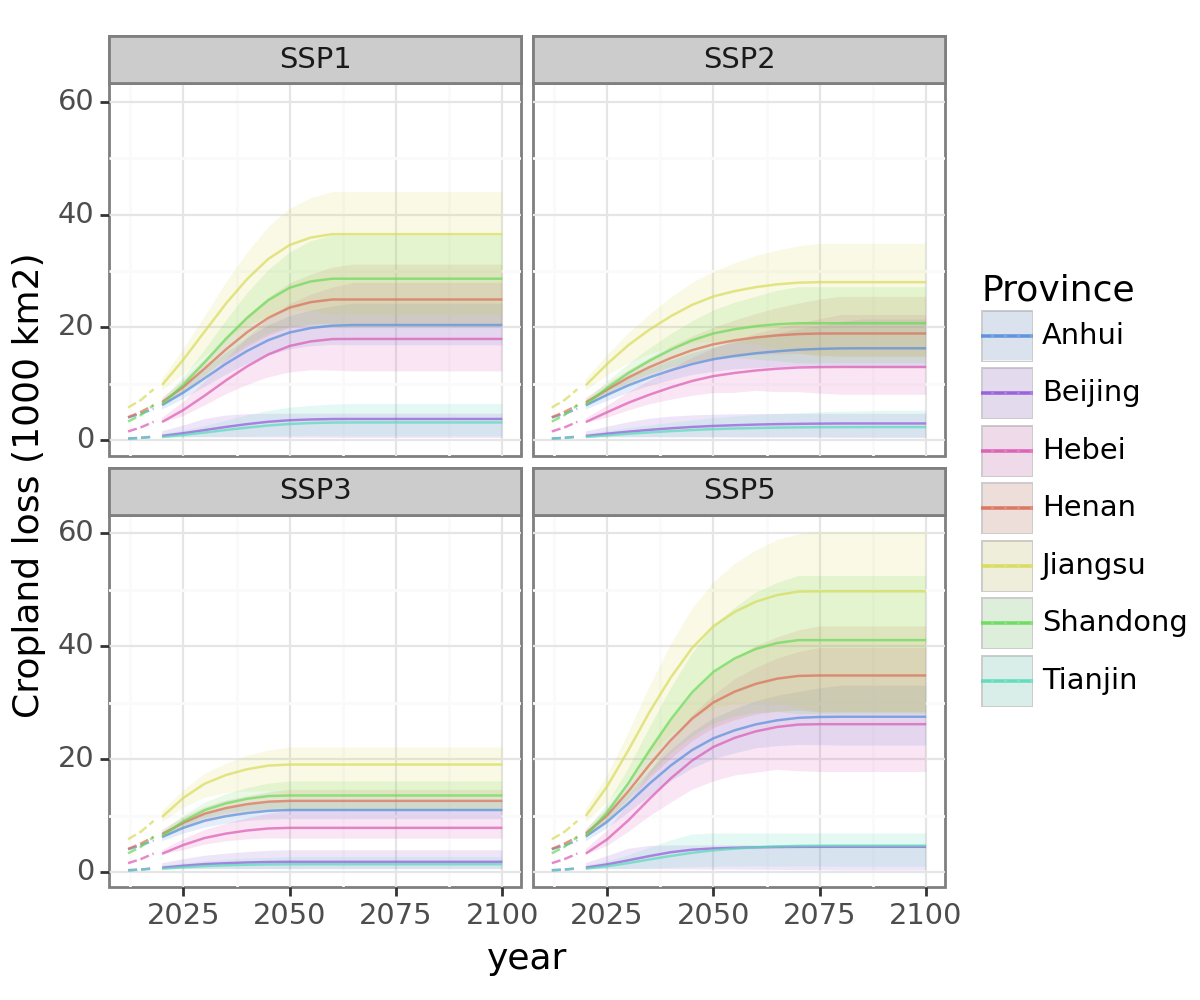

<Figure Size: (600 x 500)>

In [152]:
# seperate data to hist and pred for plotting
urban_encroachment_area_hist_df = urban_encroachment_area_df >> mask(X.Scenario == 'Historical') >> drop('Scenario')
urban_encroachment_area_pred_df = urban_encroachment_area_df >> mask(X.Scenario != 'Historical')

# plot the area change
plotnine.options.figure_size = (6,5)
plotnine.options.dip = 100

g = (ggplot()
  # historical urban encroachment
  + geom_line(urban_encroachment_area_hist_df,aes(x='year',y='encroach_area_1000km2_mean',color='Province'),alpha=0.7,linetype='dashed')
  # pred urban encroachment
  + geom_ribbon(urban_encroachment_area_pred_df 
        >> mask(~X.Scenario.isin(['SSP4'])),aes(x='year',ymin='encroach_area_1000km2_bot',                         
                            ymax='encroach_area_1000km2_top',fill='Province'),alpha=0.15)
  + geom_line(urban_encroachment_area_pred_df \
        >> mask(~X.Scenario.isin(['SSP4'])),aes(x='year',y='encroach_area_1000km2_mean',color='Province'),alpha=0.7)
  
  + facet_wrap('Scenario',nrow=2)
  + theme_bw(base_size=13)
  + scale_color_discrete(h=.6) 
  + scale_fill_discrete(h=.6)  
  + ylab('Cropland loss (1000 km2)')
  # + theme(legend_position=(1,0.5))
)

g

In [153]:
g.save('../Figs/result_2_2_urban_encroach_cropland_area.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/result_2_2_urban_encroach_cropland_area.svg


### 2) Compute the area of urban encroachment on cropland for each GAEZ grid cell

#### 2-1) First to convert GAEZ imgs to vectors

In [154]:
# fucntion to create a vector shp that has the same
# spatial resolution as GAEZ img

# define the scale for converting raw_float to intergers
GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_2011_2040_RCP26")
to_path = 'users/wangjinzhulala/Paper_3/04_GAEZ_shp'

vector = GAEZ_img.multiply(0).add(ee.Image.random().multiply(1e8)).toInt().reduceToVectors(
                          geometry=NCP_shp.geometry(), 
                          scale=GAEZ_pix_scale, 
                          maxPixels=1e13, 
                          tileScale=2, 
                          geometryInNativeProjection=True)

# # export vector to GEE
# task = ee.batch.Export.table.toAsset(
#     collection = vector, 
#     description = 'Export GAEZ_vector', 
#     assetId = f'{to_path}/GAEZ_vector'
# )

# task.start()

#### 2-2) Compute the urban excroachment in each GAEZ grid cell, then export the fe_col

In [155]:
# get the GAEZ shp file
GAEZ_shp = ee.FeatureCollection("users/wangjinzhulala/Paper_3/04_GAEZ_shp/GAEZ_vector")
stats_to_path = 'users/wangjinzhulala/Paper_3/05_GAEZ_shp_stats'

In [156]:
# compute the urban encroachment_area in each GAEZ cell
for idx,row in historical_future_urban_maps.iterrows():

  # get properties
  scenario = row['Scenario']
  name = f"{row['Scenario']}_{row['year']}"

  if scenario == 'Historical':
    img = img_bot = img_top = row['Urban_encroachment_map']
    img = img.rename('encroachment')
    img_bot = img_bot.rename('encroachment_bot')
    img_top = img_top.rename('encroachment_top')
  else:
    img = row['Urban_encroachment_map'].rename('encroachment')
    img_bot = row['Urban_encroachment_map_bot'].rename('encroachment_bot')
    img_top = row['Urban_encroachment_map_top'].rename('encroachment_top')
  
  # zonal statistics
  in_imgs = ee.Image([ee.Image.pixelArea()]*3).updateMask(ee.Image([img,img_bot,img_top]))
  stats = in_imgs.reduceRegions(collection = GAEZ_shp, 
                  reducer = 'sum', 
                  scale = 30)
  
  stats = stats.map(lambda fe: fe.set('encroachment',fe.get('area'),
                      'encroachment_bot',fe.get('area_1'),
                      'encroachment_top',fe.get('area_2')))
  
  # export
  task = ee.batch.Export.table.toAsset(
      collection = stats, 
      description = name, 
      assetId = f'{stats_to_path}/{name}'
  )

  # # start the export
  # task.start()
  # print(name)

In [157]:
# get the shp_stats
crops = ['Wetland_rice','Maize','Wheat']
shp_stats = !earthengine ls users/wangjinzhulala/Paper_3/05_GAEZ_shp_stats
shp_stats_filter = [i for i in shp_stats if not any(j in i for j in crops)]

In [158]:
# construct the shp_stats_df
shp_stats_df = pd.DataFrame({'GAEZ_shp_stats':[ee.FeatureCollection(fe) for fe in shp_stats_filter]})
shp_stats_df[['Scenario','year']] = [i.split('/')[-1].split('_') for i in shp_stats_filter]
shp_stats_df['year'] = shp_stats_df['year'].astype(int)

In [159]:
# append GAEZ shp to urban maps
SSP_future_urban_map_stats = shp_stats_df.copy()
SSP_future_urban_map_stats['crop'] = [actual_area['crop'].tolist()]*len(SSP_future_urban_map_stats)
SSP_future_urban_map_stats['water'] = [actual_area['water'].tolist()]*len(SSP_future_urban_map_stats)
SSP_future_urban_map_stats['GAEZ_2010_cropland'] = [actual_area['GEE_path'].tolist()]*len(SSP_future_urban_map_stats)

# explode the crop/water columns to conect urban maps with GAEZ cropland shp
SSP_future_urban_map_stats = SSP_future_urban_map_stats.explode(['crop','water','GAEZ_2010_cropland']).reset_index(drop=True)
SSP_future_urban_map_stats

,GAEZ_shp_stats,Scenario,year,crop,water,GAEZ_2010_cropland
0,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Maize,Rainfed,projects/earthengine-legacy/assets/users/wangj...
1,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Maize,Irrigated,projects/earthengine-legacy/assets/users/wangj...
2,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wetland_rice,Rainfed,projects/earthengine-legacy/assets/users/wangj...
3,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wetland_rice,Irrigated,projects/earthengine-legacy/assets/users/wangj...
4,"ee.FeatureCollection({\n ""functionInvocationV...",Historical,2012,Wheat,Rainfed,projects/earthengine-legacy/assets/users/wangj...
...,...,...,...,...,...,...
523,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Maize,Irrigated,projects/earthengine-legacy/assets/users/wangj...
524,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wetland_rice,Rainfed,projects/earthengine-legacy/assets/users/wangj...
525,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wetland_rice,Irrigated,projects/earthengine-legacy/assets/users/wangj...
526,"ee.FeatureCollection({\n ""functionInvocationV...",SSP5,2100,Wheat,Rainfed,projects/earthengine-legacy/assets/users/wangj...


In [160]:
# # sanity check: --> download the imgs to see if they make sense

# fe_col = (SSP_future_urban_map_stats >> mask(X.Scenario=='SSP2',X.year==2020,X.crop=='Wheat',X.water=='Irrigated'))['GAEZ_shp_stats'].tolist()[0]
# img = ee.Image().toFloat().paint(featureCollection=fe_col,color='encroachment')

# print(img.getDownloadUrl(dict(name='img',region=NCP_shp.geometry(),scale=GAEZ_pix_scale,format='GEO_TIFF')))

#### 2-3) validate the encroachment_crop/water for each GAEZ cell, which should be the same as the urban_encroachment_area_hist_df
- the result shows GAEZ_urban_encroach is 0.89 to overlay_urban_encroach
- see below process to see why this is happening

In [161]:
# compute the total encroachment area from urban_encroachment_area_hist_df
df_encroach_overlay =  urban_encroachment_area_hist_df.groupby(['year']).sum().reset_index()
df_encroach_overlay

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2368\2887806078.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,year,encroach_area_kha_mean,encroach_area_kha_top,encroach_area_kha_bot,encroach_area_1000km2_mean,encroach_area_1000km2_top,encroach_area_1000km2_bot
0,2012,1938.910268,1938.910268,1938.910268,19.389103,19.389103,19.389103
1,2015,2445.958996,2445.958996,2445.958996,24.459590,24.459590,24.459590
2,2018,3155.530232,3155.530232,3155.530232,31.555302,31.555302,31.555302


In [162]:
# compute the total cropland area in the NCP
total_area_img = ee.ImageCollection([ee.Image(path).unmask() for path in  actual_area['GEE_path']]).sum()
total_area_val = total_area_img.reduceRegion(reducer='sum', geometry=NCP_shp.geometry(), scale=GAEZ_pix_scale).getInfo()['b1']

# compute the area of each crop in the NCP
crop_area = list(map(lambda img:img.reduceRegion(reducer='sum',geometry=NCP_shp.geometry(),scale=GAEZ_pix_scale).getInfo()['b1'],
         [ee.Image(path) for path in  actual_area['GEE_path']]))

# compute the area_ratio of each crop to the total cropland
crop_area_ratio = pd.DataFrame({'crop':actual_area['crop'],'water':actual_area['water'],'ratio':np.array(crop_area)/total_area_val})
crop_area_ratio

,crop,water,ratio
0,Maize,Rainfed,0.083999
1,Maize,Irrigated,0.292468
2,Wetland_rice,Rainfed,0.000000
3,Wetland_rice,Irrigated,0.207888
4,Wheat,Rainfed,0.047158
5,Wheat,Irrigated,0.368486


In [163]:
# select valid historical rows
SSP_future_urban_map_stats_hist = SSP_future_urban_map_stats >> mask(X.Scenario == 'Historical')
SSP_future_urban_map_stats_hist = SSP_future_urban_map_stats_hist >> mask(~((X.crop=='Wetland_rice')&(X.water=='Rainfed')))

# get the encroachment pix count, then compute the area
SSP_future_urban_map_stats_hist['GAEZ_encoachment_kha'] = SSP_future_urban_map_stats_hist \
                    .apply(lambda row:row['GAEZ_shp_stats'].aggregate_sum('encroachment').getInfo()/10000/1000,1)

# link the crop_area_ratio, which is used to compute the urban_encroachment on each crop
SSP_future_urban_map_stats_hist = SSP_future_urban_map_stats_hist.merge(crop_area_ratio)
SSP_future_urban_map_stats_hist['GAEZ_actual_encroachment_kha'] = SSP_future_urban_map_stats_hist['GAEZ_encoachment_kha'] \
                                    * SSP_future_urban_map_stats_hist['ratio']

# save to disk
SSP_future_urban_map_stats_hist.to_csv('./result_csv/SSP_future_urban_map_stats_hist.csv',index=False)

In [164]:
# get the encroachment from GAEZ grid cells
df_encroach_GAEZ = SSP_future_urban_map_stats_hist.groupby('year').sum().reset_index()

df_encroach_GAEZ['GAEZ_actual_encroachment_kha'] / df_encroach_overlay['encroach_area_kha_mean']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2368\1403836525.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


0    0.995536
1    0.995073
2    0.995266
dtype: float64

### 3) compute the cropland area after urbanization

#### 3-1) compute the encroachment

In [165]:
# append crop_area_ratio of each rainfed/irrigated to the stats
SSP_future_urban_map_stats_water_ratio = SSP_future_urban_map_stats.copy()
SSP_future_urban_map_stats_water_ratio = SSP_future_urban_map_stats.merge(GAEZ_cropland_2010_corrected)
SSP_future_urban_map_stats_water_ratio = SSP_future_urban_map_stats_water_ratio[['Scenario', 'year', 'crop', 'water', 
                            'GAEZ_shp_stats', 'GAEZ_2010_cropland_corrcted', 'area_ratio']]
                                          
SSP_future_urban_map_stats_water_ratio.head()

,Scenario,year,crop,water,GAEZ_shp_stats,GAEZ_2010_cropland_corrcted,area_ratio
0,Historical,2012,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,Historical,2015,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,Historical,2018,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,SSP1,2020,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,SSP1,2025,Maize,Rainfed,"ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [166]:
# function to compute urban encroachment on cropland
def compute_urban_encroachment(row):

  # get properties
  fe = row['GAEZ_shp_stats']
  GAEZ_cropland_2010 = row['GAEZ_2010_cropland_corrcted']
  area_ratio_img = row['area_ratio']

  # get encroach imgs (kha)
  encroach_img = ee.Image().paint(featureCollection=fe,color='encroachment').multiply(area_ratio_img).divide(10000*1000)
  encroach_img_bot = ee.Image().paint(featureCollection=fe,color='encroachment_bot').multiply(area_ratio_img).divide(10000*1000)
  encroach_img_top = ee.Image().paint(featureCollection=fe,color='encroachment_top').multiply(area_ratio_img).divide(10000*1000)

  # get the future farmland_area (kha) 
  future_farmland = GAEZ_cropland_2010.subtract(encroach_img).rename(f'encroachment_led_farmland')
  future_farmland_bot = GAEZ_cropland_2010.subtract(encroach_img_bot).rename(f'encroachment_led_farmland_bot')
  future_farmland_top = GAEZ_cropland_2010.subtract(encroach_img_top).rename(f'encroachment_led_farmland_top')

  # convert negative values to 0, because cropland area can't be negative
  future_farmland = future_farmland.mask(future_farmland.gt(0)).unmask()
  future_farmland_bot = future_farmland_bot.mask(future_farmland_bot.gt(0)).unmask()
  future_farmland_top = future_farmland_top.mask(future_farmland_top.gt(0)).unmask()

  future_farmland_combine = ee.Image([future_farmland,future_farmland_bot,future_farmland_top])

  # return future famland area as raster img
  return future_farmland_combine

In [167]:
# compute future harvested area and save the df to disk
urban_encroach_img = SSP_future_urban_map_stats_water_ratio.copy()
urban_encroach_img['cropland_encroached_by_urban'] = urban_encroach_img.apply(lambda row:compute_urban_encroachment(row),1)

urban_encroach_img = urban_encroach_img >> select(['Scenario','year','crop','water','cropland_encroached_by_urban'])
urban_encroach_img.to_pickle('./result_csv/urban_encroach_img.pkl')

In [168]:
# # sanity check: --> download the imgs to see if they make sense

# img = urban_encroach_img.iloc[0]['cropland_encroached_by_urban']
# print(img.getDownloadUrl(dict(name='img',region=NCP_shp.geometry(),scale=GAEZ_pix_scale,format='GEO_TIFF')))

#### 3-2) validate the encroachment

In [169]:
# function to compute cropland area after urban encroachment
def compute_cropland_by_encroachment(in_df):
  print(' ',end='',flush=True)

  out_dfs=[]

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):

    # get properties
    ssp = row['Scenario']
    year = row['year']
    water = row['water']
    crop = row['crop']

    # judge if the img comes from the historical 
    if ssp == 'Historical':
      in_img = ee.Image([row['cropland_encroached_by_urban'].select('encroachment_led_farmland')]*3)
    else:
      in_img = row['cropland_encroached_by_urban']

    # compute the area of the input img
    stats = in_img.reduceRegions(collection=NCP_shp,
                    scale=GAEZ_pix_scale,
                    reducer=ee.Reducer.sum().repeat(3)).getInfo()

    # contructe the stats_df
    stats_data = pd.DataFrame({i['properties']['EN_Name']:i['properties']['sum'] 
                    for i in stats['features']}).T.reset_index()

    stats_data.columns = ['Province','area_after_encroachment_kha','area_after_encroachment_kha_bot',
                'area_after_encroachment_kha_top']
    
    stats_data['Scenario'] = ssp
    stats_data['crop'] = crop
    stats_data['water'] = water
    stats_data['year'] = year

    out_dfs.append(stats_data)

  return pd.concat(out_dfs)


In [172]:
# # get the cropland area (crop/water) after urban encroachment
# cropland_area_after_encroachment = parallelize_dataframe(urban_encroach_img,compute_cropland_by_encroachment,30).reset_index(drop=True)

# # save to disk
# cropland_area_after_encroachment.to_csv('./result_csv/cropland_area_after_encroachment.csv',index=False)

# read data
cropland_area_after_encroachment = pd.read_csv('./result_csv/cropland_area_after_encroachment.csv')

# get the total cropland area
cropland_area_after_encroachment_sum = cropland_area_after_encroachment.groupby(['Scenario','year','Province']).sum().reset_index()
cropland_area_after_encroachment_sum

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2368\293494162.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Scenario,year,Province,area_after_encroachment_kha,area_after_encroachment_kha_bot,area_after_encroachment_kha_top
0,Historical,2012,Anhui,5392.177257,5392.177257,5392.177257
1,Historical,2012,Beijing,199.370204,199.370204,199.370204
2,Historical,2012,Hebei,5537.473013,5537.473013,5537.473013
3,Historical,2012,Henan,8759.613978,8759.613978,8759.613978
4,Historical,2012,Jiangsu,4297.095995,4297.095995,4297.095995
...,...,...,...,...,...,...
611,SSP5,2100,Hebei,3309.378761,4046.135336,2293.393914
612,SSP5,2100,Henan,5861.339809,6448.604105,5101.632039
613,SSP5,2100,Jiangsu,1068.366734,2391.410605,520.363630
614,SSP5,2100,Shandong,3446.309049,4463.705458,2671.365891


In [173]:
# get the sum of yearbook cropland area records
yearbook_area_sum = yearbook_area.groupby(['Province','year']).sum().reset_index()
yearbook_area_sum.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2368\4275360802.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Province,year,area_yearbook_kha
0,Anhui,2002,4752.40
1,Anhui,2003,4611.80
2,Anhui,2004,4851.90
3,Anhui,2005,4927.60
4,Anhui,2006,5138.64


C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


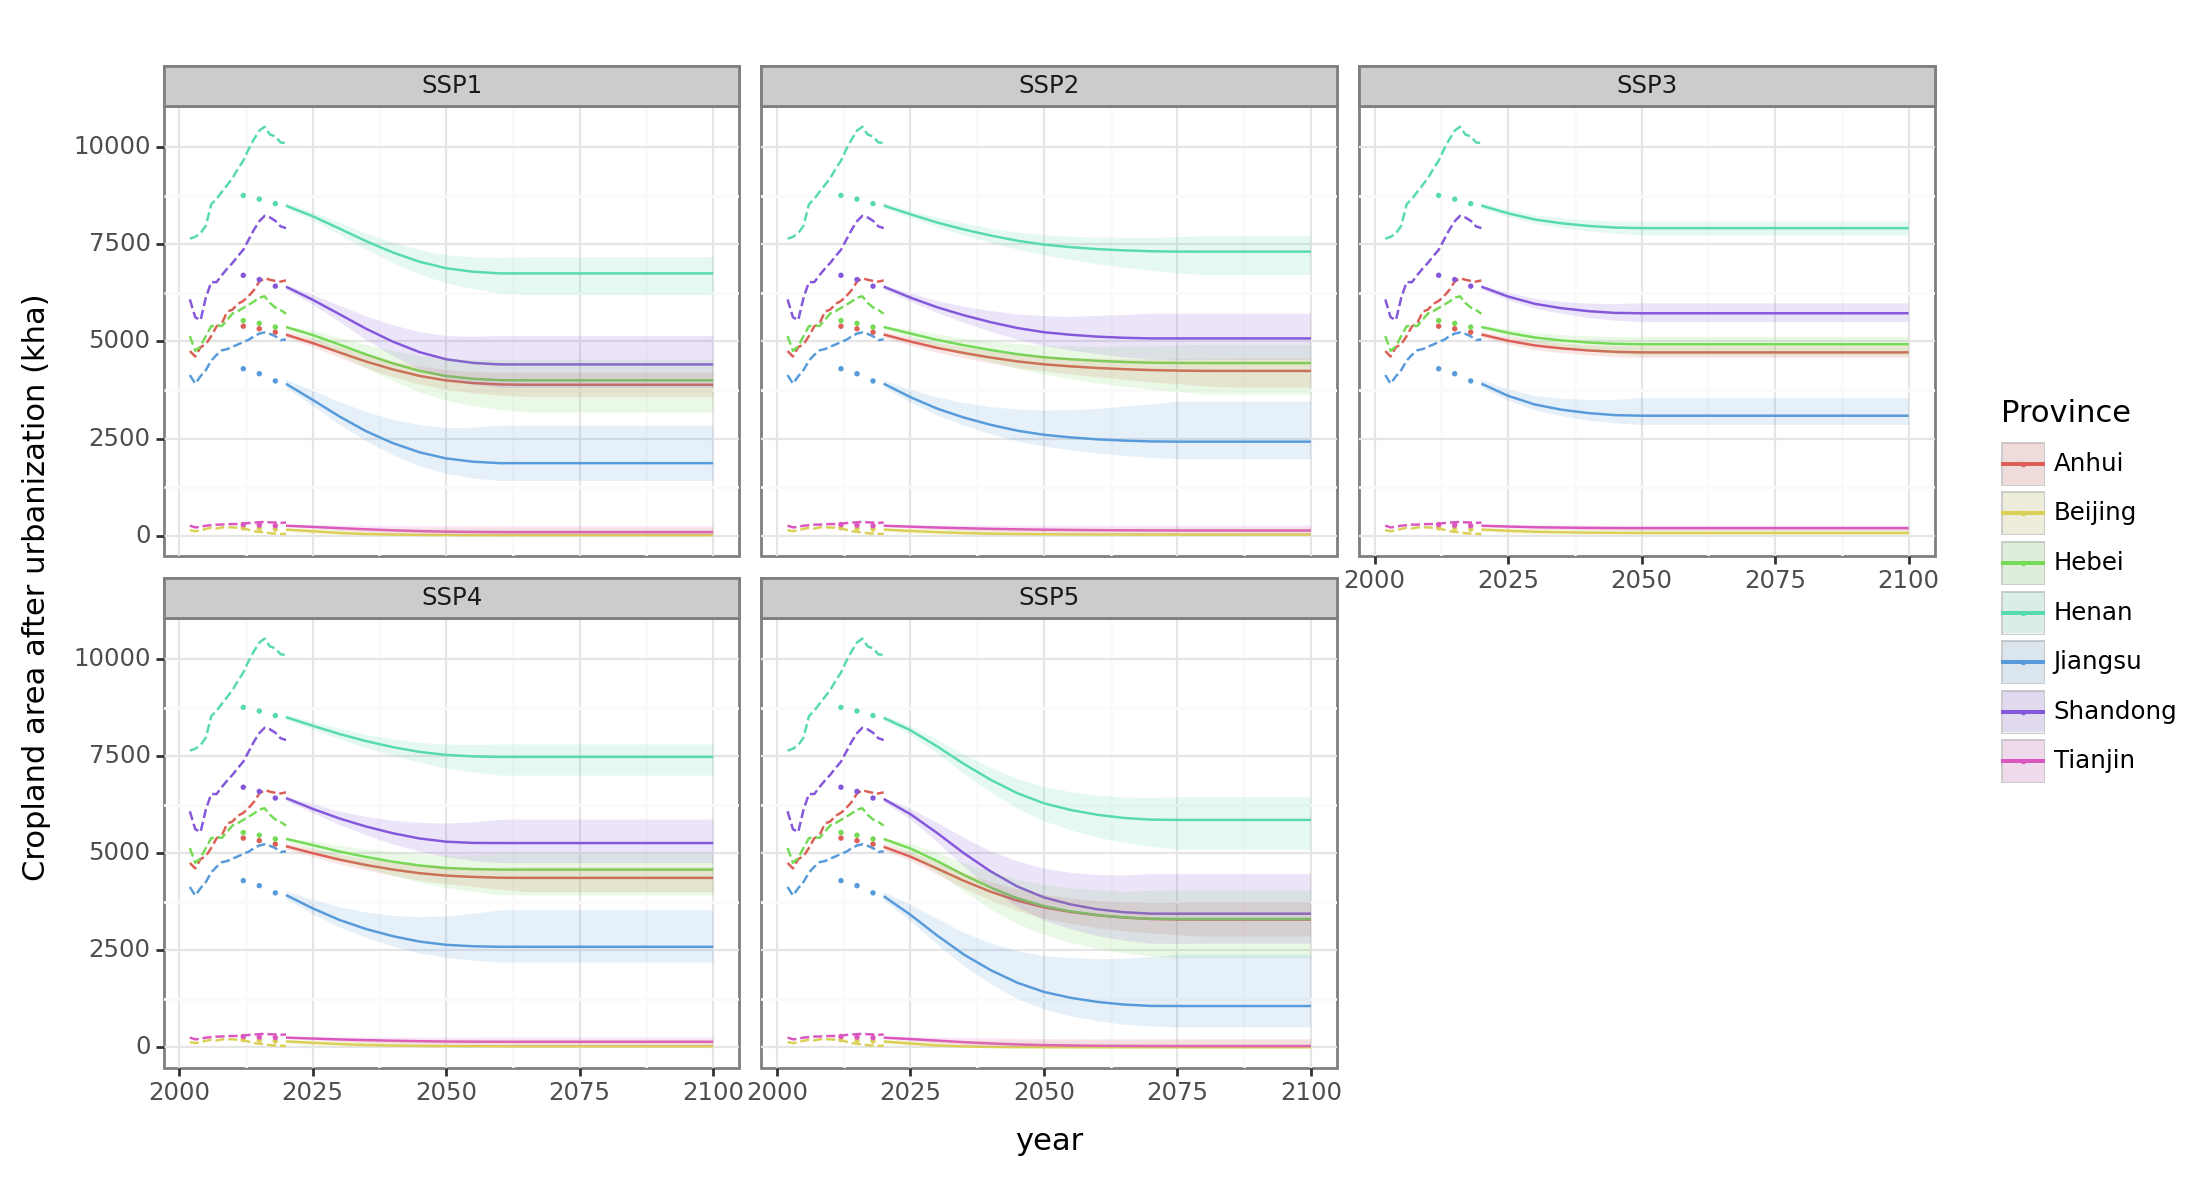

<Figure Size: (1100 x 600)>

In [174]:
# seperate df for ploting
cropland_area_after_encroachment_sum_hist = cropland_area_after_encroachment_sum \
                      >> mask(X.Scenario == 'Historical') >> drop('Scenario')
cropland_area_after_encroachment_sum_pred = cropland_area_after_encroachment_sum >> mask(X.Scenario != 'Historical')                     


# plot the area change
plotnine.options.figure_size = (11,6)
plotnine.options.dip = 100

# plot the cropland_area_after_encroachment_sum
g= (ggplot()
 # yearbook cropland area
 + geom_line(yearbook_area_sum,aes(x='year',y='area_yearbook_kha',color='Province'),linetype='dashed')
 # cropland after urban encroachment hist
 + geom_point(cropland_area_after_encroachment_sum_hist,aes(x='year',y='area_after_encroachment_kha',color='Province'),size=0.1)
 # cropland after urban encroachment pred
 + geom_line(cropland_area_after_encroachment_sum_pred,aes(x='year',y='area_after_encroachment_kha',color='Province'))
 + geom_ribbon(cropland_area_after_encroachment_sum_pred,
          aes(x='year',ymax='area_after_encroachment_kha_top',ymin='area_after_encroachment_kha_bot',fill='Province'),alpha=0.15)
 + facet_wrap(['Scenario'],ncol=3)
 + theme_bw()
 + theme(subplots_adjust={'wspace': 0.15})
 + ylab('Cropland area after urbanization (kha)')
 )

g


In [175]:
g.save('../Figs/sup_7_cropland_area_after_urbanization.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 11 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_7_cropland_area_after_urbanization.svg
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\themes\themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.
